# sigma54-RNAP-Cy3 binding to 597P255

Fig. 1E in [RNA polymerase approaches its promoter without
long-range sliding along DNA](https://www.pnas.org/content/pnas/110/24/9740.full.pdf)

## Setup

In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import pi, resample
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos, HMM
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.imscroll import time_to_first_binding

from tapqir.utils.stats import ci_from_trace
from tapqir.utils.mle_analysis import train, ttfb_model, ttfb_guide

## View Data

In [2]:
# load glimpse
path_data = Path("/shared/centaur/data/LarryCy3sigma54/")
glimpse = GlimpseDataset(path_data)

# load model & parameters
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

### AOIs

In [3]:
glimpse.aoiinfo["test"]

,frame,ave,x,y,pixnum
aoi,,,,,
1,4576.0,3.0,465.800874,166.115977,7.0
2,4576.0,3.0,461.890749,158.269997,7.0
3,4576.0,3.0,462.586798,216.967306,7.0
4,4576.0,3.0,450.603082,216.631839,7.0
5,4576.0,3.0,438.751026,248.921980,7.0
...,...,...,...,...,...
98,4576.0,3.0,288.674885,169.382946,7.0
99,4576.0,3.0,442.985487,60.207967,7.0
100,4576.0,3.0,337.499860,78.386376,7.0


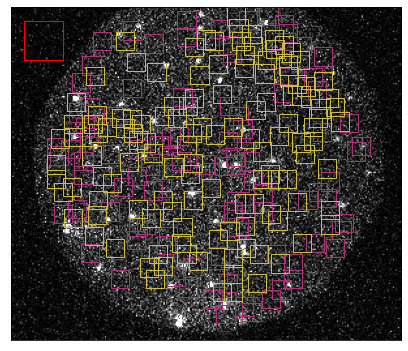

In [4]:
plt.figure(figsize=(7, 7))

frame = 2078 - 47
# plot selected area of the image
plt.imshow(glimpse[frame][256:], cmap="gray",
           vmin=model.data.vmin, vmax=model.data.vmax)

for aoi in glimpse.aoiinfo["test"].index:
    # on-target area
    y_pos = round(glimpse.aoiinfo["test"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["test"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5 - 256
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

for aoi in glimpse.aoiinfo["control"].index:
    # off-target area
    y_pos = round(glimpse.aoiinfo["control"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["control"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5 - 256
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#CCBB44", lw=1, facecolor="none"))
    

plt.gca().add_patch(Rectangle((10, 10), 30, 30,
                    edgecolor="r", lw=1, facecolor="none"))
    
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Driftlist

In [5]:
glimpse.cumdrift

,dx,dy
frame,,
170,3.223052,0.140329
171,3.223052,0.140329
172,3.223531,0.142883
173,3.223993,0.145426
174,3.224437,0.147959
...,...,...
4572,-0.002196,-0.001024
4573,-0.001778,-0.000818
4574,-0.001350,-0.000612


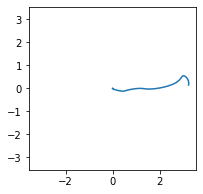

In [6]:
plt.figure(figsize=(3,3))
plt.plot(glimpse.cumdrift["dx"], glimpse.cumdrift["dy"])
lim = glimpse.cumdrift.abs().max().max() * 1.1
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

### Offset

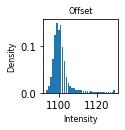

In [7]:
plt.figure(figsize=(1.35,1.35))
plt.bar(model.data.offset_samples, model.data.offset_weights)
plt.title("Offset", fontsize=8)
plt.ylabel("Density", fontsize=8)
plt.xlabel("Intensity", fontsize=8)
plt.show()

### Global parameters

In [11]:
fit = pd.read_csv(
            path_params / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename("sigma54RNAPCy3-597P255")
fit

snr                3.9343507289886475
gain_mean          11.171667098999023
gain_ll            11.171667098999023
gain_ul            11.171667098999023
pi_mean           0.08583381026983261
pi_ll             0.08583381026983261
pi_ul             0.08583381026983261
lamda_mean          0.164918452501297
lamda_ll            0.164918452501297
lamda_ul            0.164918452501297
proximity_mean    0.46530988812446594
proximity_ll      0.46530988812446594
proximity_ul      0.46530988812446594
marginal                         True
classifier                       True
MCC                0.9734214941198143
Recall             0.9673316887409288
Precision          0.9844732608589675
TN                             407124
FP                                637
FN                               1364
TP                              40389
z_median            0.977536678314209
z_ll               0.9379876852035522
z_ul               0.9860079288482666
Name: sigma54RNAPCy3-597P255, dtype: object

## Figures

### Figure 4

In [10]:
model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

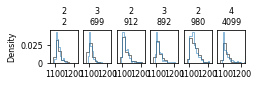

In [26]:
aois = [2, 3, 2, 3, 2, 4]
frames = [2, 699, 912, 892, 980, 4099]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(1070, model.data.vmax+50),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(1070, model.data.vmax+50),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(1070, model.data.vmax+50)
    plt.xticks([1100, 1200], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/597P255-hist.svg")

plt.show()

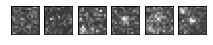

In [27]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=1070, vmax=1200, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/597P255-data.png", dpi=600)

plt.show()

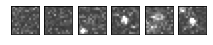

In [28]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=1070, vmax=1200, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/597P255-sample.png", dpi=600)

plt.show()

### Figure 7

#### Ratergram

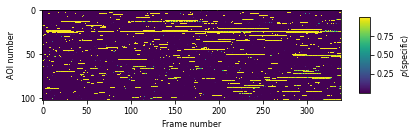

In [3]:
path_data = Path("/shared/centaur/data/LarryCy3sigma54/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

# on-target
ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[:, ::13], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

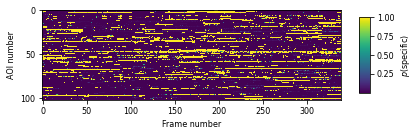

In [4]:
# off-target
plt.figure(figsize=(6, 2))
plt.imshow(1 - (1 - model.j_probs[:, :, ::13]).prod(0), aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

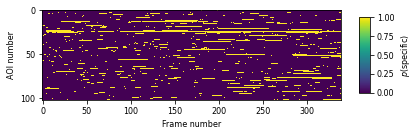

In [5]:
# spotpicker
ttfb = time_to_first_binding(model.data.labels["z"])
# sort ttfb
sdx = np.flip(np.argsort(ttfb))


plt.figure(figsize=(6, 2))
plt.imshow(model.data.labels["z"][:, ::13], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

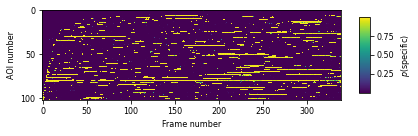

In [6]:
# sorted on-target
ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[sdx][:, ::13], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure7/597P255-rastegram.png", dpi=900)
plt.show()

#### Tapqir fit

In [7]:
z_marginal = model.z_marginal.data
control = None
Tmax = model.data.F

z = dist.Bernoulli(z_marginal).sample((1000,))
data = time_to_first_binding(z)

In [8]:
train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax, jit=True
)

/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:181: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif reversed_shape[i] == 1 and not strict:
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:183: TracerWarning: Converting a tensor to a Python 

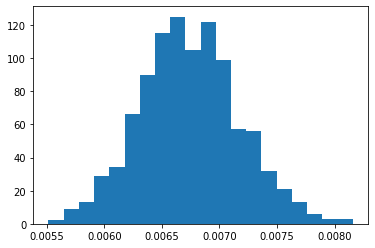

In [9]:
plt.hist(pyro.param("ka").data.squeeze().numpy(), bins=20)
plt.show()

In [10]:
ka_mean = pyro.param("ka").data.mean()
ka_ll, ka_ul = pi(pyro.param("ka").data.squeeze(), 0.68, dim=0)
ka_mean.item(), ka_ll.item(), ka_ul.item()

(0.0067404452711343765, 0.006322040222585201, 0.007181749679148197)

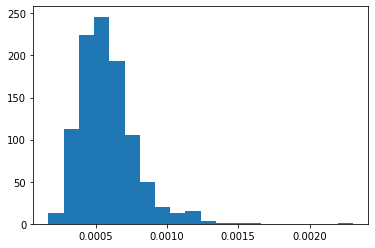

In [11]:
plt.hist(pyro.param("kns").data.squeeze().numpy(), bins=20)
plt.show()

In [12]:
kns_mean = pyro.param("kns").data.mean()
kns_ll, kns_ul = pi(pyro.param("kns").data.squeeze(), 0.68, dim=0)
kns_mean.item(), kns_ll.item(), kns_ul.item()

(0.0005820272490382195, 0.0004011892597191036, 0.0007427712553180754)

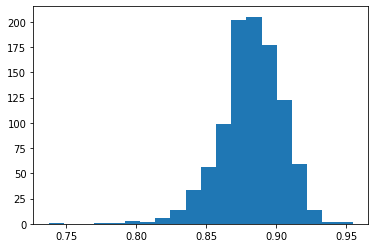

In [13]:
plt.hist(pyro.param("Af").data.squeeze().numpy(), bins=20)
plt.show()

In [14]:
Af_mean = pyro.param("Af").data.mean()
Af_ll, Af_ul = pi(pyro.param("Af").data.squeeze(), 0.68, dim=0)
Af_mean.item(), Af_ll.item(), Af_ul.item()

(0.8817737698554993, 0.8622501492500305, 0.9027194380760193)

In [46]:
nz = (data == 0).sum(1, keepdim=True)
n = (data == Tmax).sum(1, keepdim=True)
N = data.shape[1]

In [47]:
fraction_bound = (data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

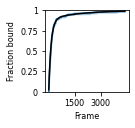

In [49]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (pyro.param("Af").data*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).data * torch.arange(Tmax))) +
    (1 - pyro.param("Af").data)*(1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure7/597P255-tapqir.svg")
plt.show()

#### Spotpicker fit

In [15]:
Tmax = model.data.F

spotpicker_data = time_to_first_binding(model.data.labels["z"])
spotpicker_data = torch.tensor(spotpicker_data, dtype=torch.float)
spotpicker_control = time_to_first_binding(model.control.labels["z"])
spotpicker_control = torch.tensor(spotpicker_control, dtype=torch.float)

bootstrap_data = torch.stack(
    [resample(spotpicker_data, num_samples=len(spotpicker_data), replacement=True) for _ in range(1000)],
    dim=0
)
bootstrap_control = torch.stack(
    [resample(spotpicker_control, num_samples=len(spotpicker_control), replacement=True) for _ in range(1000)],
    dim=0
)

In [16]:
train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=bootstrap_data, control=bootstrap_control, Tmax=Tmax, jit=True
)

/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:181: TracerWarn

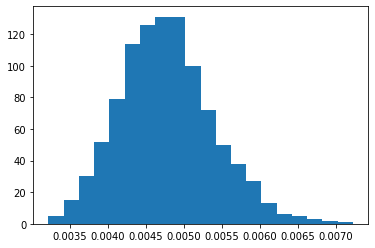

In [17]:
plt.hist(pyro.param("ka").data.squeeze().numpy(), bins=20)
plt.show()

In [18]:
ka_mean = pyro.param("ka").data.mean()
ka_ll, ka_ul = pi(pyro.param("ka").data.squeeze(), 0.68, dim=0)
ka_mean.item(), ka_ll.item(), ka_ul.item()

(0.004775614943355322, 0.0041734082624316216, 0.005376510787755251)

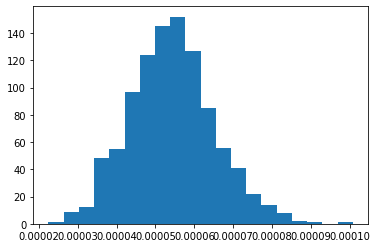

In [19]:
plt.hist(pyro.param("kns").data.squeeze().numpy(), bins=20)
plt.show()

In [20]:
kns_mean = pyro.param("kns").data.mean()
kns_ll, kns_ul = pi(pyro.param("kns").data.squeeze(), 0.68, dim=0)
kns_mean.item(), kns_ll.item(), kns_ul.item()

(5.4284875659504905e-05, 4.342606553109363e-05, 6.477421993622556e-05)

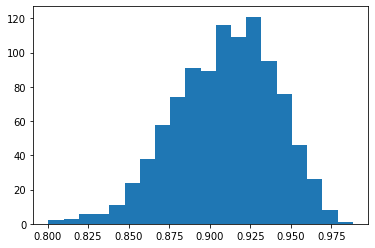

In [21]:
plt.hist(pyro.param("Af").data.squeeze().numpy(), bins=20)
plt.show()

In [22]:
Af_mean = pyro.param("Af").data.mean()
Af_ll, Af_ul = pi(pyro.param("Af").data.squeeze(), 0.68, dim=0)
Af_mean.item(), Af_ll.item(), Af_ul.item()

(0.9092426896095276, 0.8777886629104614, 0.9409378170967102)

In [23]:
nz = (bootstrap_data == 0).sum(1, keepdim=True)
n = (bootstrap_data == Tmax).sum(1, keepdim=True)
N = bootstrap_data.shape[1]

nzc = (bootstrap_control == 0).sum(1, keepdim=True)
nc = (bootstrap_control == Tmax).sum(1, keepdim=True)
Nc = bootstrap_control.shape[1]

In [24]:
fraction_bound = (bootstrap_data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

fraction_boundc = (bootstrap_control.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fbc_ll, fbc_ul = pi(fraction_boundc, 0.68, dim=0)

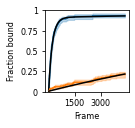

In [26]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (pyro.param("Af").data*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).data * torch.arange(Tmax))) +
    (1 - pyro.param("Af").data)*(1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.fill_between(
    torch.arange(Tmax),
    fbc_ll, fbc_ul,
    alpha=0.3, color="C1"
)
plt.plot(torch.arange(Tmax), fraction_boundc.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax)))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure7/599P255-spotpicker.svg")
plt.show()